In [1]:
IRT_DIMS = 1
TEST = False

In [2]:
import sys, os, shutil
import pickle
import time
import numpy as np
from utils import (mymode, load_data_heterogeneous, create_data_object_heterogeneous)

from IRT import MIRT_2PL
from Heterogeneous_embedder import EmbedderHeterogeneous, train_embedder_heterogeneous, test_embedder_heterogeneous
from manage_experiments import perform_cross_validation

import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

MAXES = 10
MINEPOCHS = 5

In [3]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# Initialise
parameters = {
    'df_name': None,
    'epochs': 10000,
    'learning_rate': 0.005,
    'weight_decay': 0,
    'early_stopping': 200,
    'n_splits': 3,
    'device': 'cuda:0',
    'batch_size': 1024
    }

if IRT_DIMS > 0:
    parameters['model_type'] = 'IRT'
    parameters['hidden_dims'] = IRT_DIMS
    parameters['lambda1'] = 0.01
    parameters['lambda2'] = 0.02
    OUTNAME = 'IRT'
else:
    parameters['model_type'] = 'GNN'
    parameters['hidden_dims'] = [16,8]
    OUTNAME = 'SAGE' 

In [5]:
if TEST: 
    #DATA_FILE = 'data/mindsteps_set_matrix_20000'    
    DATA_FILE = 'data/mindsteps_set_test_matrix'    
else:
    DATA_FILE = 'data/mindsteps_set_full' 

In [6]:
df = load_data_heterogeneous(DATA_FILE)
data, df_student, df_item, df_edge = create_data_object_heterogeneous(df, return_aux_data=True)

(327841, 24)


In [7]:
df.columns

Index(['studentId', 'code', 'motherTongue', 'Gender', 'scale', 'matrix',
       'IRT_difficulty', 'topic', 'responseformat', 'textlength', 'score',
       'age', 'grade', 'viewingTime', 'timestamp', 'useCase', 'assessmentId',
       'ability', 'frequency', 'previous_sessions', 'years_from_start',
       'matdiff', 'matcode', 'domain'],
      dtype='object')

In [8]:
df.head()

,studentId,code,motherTongue,Gender,scale,matrix,IRT_difficulty,topic,responseformat,textlength,...,timestamp,useCase,assessmentId,ability,frequency,previous_sessions,years_from_start,matdiff,matcode,domain
0,0,0,0.0,0.0,dles,D.2.B.1.f,0.268748,Zeitungsartikel,NaN,NaN,...,7.643058e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d
1,0,1,0.0,0.0,dles,D.2.B.1.h,1.217388,Textsorten erkennen,single choice,NaN,...,7.643061e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d
2,0,2,0.0,0.0,dles,D.2.B.1.h,1.584145,Wissenstexte: Mix,single choice,NaN,...,7.845624e-312,ms-kber,E109B3CDD31EDCFE7F48665587372C60A3FAEBB8571544...,2.421279,4.137915,6,1.45,,,d
3,0,3,0.0,0.0,dles,D.2.B.1.h,1.584145,Wissenstexte: Mix,single choice,NaN,...,7.851631e-312,ms-kber,319A0FE3AFDC0A30C4C1B26577B5B19FE66E918A181354...,2.174872,7.432378,11,1.48,,,d
4,0,4,0.0,0.0,dles,D.2.C.1.h,1.172410,Geschichten lang,single choice,NaN,...,7.643059e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d


edge_dim = data['student', 'responds', 'item'].edge_attr.shape[1]
if IRT_DIMS > 0:
    model = MIRT_2PL(IRT_DIMS, edge_dim, data)
else:
    model = EmbedderHeterogeneous( 
        n_students =  data['student'].x.size(0),
        n_items = data['item'].x.size(0),
        student_inchannel = data['student'].x.size(1),
        item_inchannel = data['item'].x.size(1),
        hidden_channels=parameters['hidden_dims'],
        edge_channel=edge_dim,
        metadata=data.metadata()
        ).to(device)
    
model = model.to(device)

In [9]:
output_dict, model = perform_cross_validation(data, parameters, save_embeddings=True, save_subgraph=True, final_fit=True)

0it [00:00, ?it/s]
  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 45.10it/s]



Epoch: 001, Loss: 40516.1055, Val: 0.5025, Test: 0.4969



  0%|          | 1/10000 [00:01<2:59:07,  1.07s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 24.58it/s]



Epoch: 002, Loss: 39894.3008, Val: 0.5039, Test: 0.4982



  0%|          | 2/10000 [00:02<3:15:11,  1.17s/it]

100%|██████████| 4/4 [00:00<00:00, 41.78it/s]



Epoch: 003, Loss: 39272.3242, Val: 0.5057, Test: 0.5000



  0%|          | 3/10000 [00:03<3:18:34,  1.19s/it]

100%|██████████| 4/4 [00:00<00:00, 47.30it/s]



Epoch: 004, Loss: 38660.0312, Val: 0.5069, Test: 0.5016



  0%|          | 4/10000 [00:04<2:58:57,  1.07s/it]

100%|██████████| 4/4 [00:00<00:00, 47.28it/s]



Epoch: 005, Loss: 38060.5625, Val: 0.5085, Test: 0.5028



  0%|          | 5/10000 [00:05<3:08:12,  1.13s/it]

100%|██████████| 4/4 [00:00<00:00, 45.51it/s]



Epoch: 006, Loss: 37475.2422, Val: 0.5097, Test: 0.5041



  0%|          | 6/10000 [00:06<3:04:49,  1.11s/it]

100%|██████████| 4/4 [00:00<00:00, 55.87it/s]



Epoch: 007, Loss: 36904.6016, Val: 0.5116, Test: 0.5059



  0%|          | 7/10000 [00:07<2:50:14,  1.02s/it]

100%|██████████| 4/4 [00:00<00:00, 54.75it/s]



Epoch: 008, Loss: 36348.7852, Val: 0.5133, Test: 0.5071



  0%|          | 8/10000 [00:08<2:43:59,  1.02it/s]

100%|██████████| 4/4 [00:00<00:00, 44.76it/s]



Epoch: 009, Loss: 35807.6992, Val: 0.5146, Test: 0.5082



  0%|          | 9/10000 [00:09<2:41:31,  1.03it/s]

100%|██████████| 4/4 [00:00<00:00, 57.66it/s]



Epoch: 010, Loss: 35281.1172, Val: 0.5157, Test: 0.5100



  0%|          | 10/10000 [00:10<2:39:21,  1.04it/s]

100%|██████████| 4/4 [00:00<00:00, 42.42it/s]



Epoch: 011, Loss: 34768.6914, Val: 0.5172, Test: 0.5109



  0%|          | 11/10000 [00:11<2:37:59,  1.05it/s]

100%|██████████| 4/4 [00:00<00:00, 44.35it/s]



Epoch: 012, Loss: 34270.0391, Val: 0.5189, Test: 0.5122



  0%|          | 12/10000 [00:12<2:45:48,  1.00it/s]

100%|██████████| 4/4 [00:00<00:00, 42.90it/s]



Epoch: 013, Loss: 33784.7461, Val: 0.5201, Test: 0.5136



  0%|          | 13/10000 [00:13<2:36:07,  1.07it/s]

100%|██████████| 4/4 [00:00<00:00, 58.78it/s]



Epoch: 014, Loss: 33312.3867, Val: 0.5218, Test: 0.5151



  0%|          | 14/10000 [00:13<2:28:01,  1.12it/s]

100%|██████████| 4/4 [00:00<00:00, 57.55it/s]



Epoch: 015, Loss: 32852.5078, Val: 0.5233, Test: 0.5168



  0%|          | 15/10000 [00:14<2:29:14,  1.12it/s]

100%|██████████| 4/4 [00:00<00:00, 46.49it/s]



Epoch: 016, Loss: 32404.7051, Val: 0.5248, Test: 0.5178



  0%|          | 16/10000 [00:15<2:28:55,  1.12it/s]

100%|██████████| 4/4 [00:00<00:00, 44.74it/s]



Epoch: 017, Loss: 31968.5527, Val: 0.5263, Test: 0.5195



  0%|          | 17/10000 [00:16<2:24:54,  1.15it/s]

100%|██████████| 4/4 [00:00<00:00, 54.90it/s]



Epoch: 018, Loss: 31543.6426, Val: 0.5269, Test: 0.5204



  0%|          | 18/10000 [00:17<2:25:46,  1.14it/s]

100%|██████████| 4/4 [00:00<00:00, 42.40it/s]



Epoch: 019, Loss: 31129.6016, Val: 0.5279, Test: 0.5221



  0%|          | 19/10000 [00:18<2:24:03,  1.15it/s]

100%|██████████| 4/4 [00:00<00:00, 49.61it/s]



Epoch: 020, Loss: 30726.0488, Val: 0.5292, Test: 0.5237



  0%|          | 20/10000 [00:18<2:15:24,  1.23it/s]

100%|██████████| 4/4 [00:00<00:00, 57.11it/s]



Epoch: 021, Loss: 30332.6348, Val: 0.5303, Test: 0.5252



  0%|          | 21/10000 [00:19<2:14:26,  1.24it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 32.97it/s]



Epoch: 022, Loss: 29949.0195, Val: 0.5314, Test: 0.5259



  0%|          | 22/10000 [00:20<2:24:03,  1.15it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 35.13it/s]



Epoch: 023, Loss: 29574.8770, Val: 0.5326, Test: 0.5272



  0%|          | 23/10000 [00:21<2:29:11,  1.11it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 28.39it/s]



Epoch: 024, Loss: 29209.9062, Val: 0.5344, Test: 0.5288



  0%|          | 24/10000 [00:22<2:23:14,  1.16it/s]

100%|██████████| 4/4 [00:00<00:00, 53.27it/s]



Epoch: 025, Loss: 28853.8047, Val: 0.5352, Test: 0.5304



  0%|          | 25/10000 [00:23<2:23:29,  1.16it/s]

100%|██████████| 4/4 [00:00<00:00, 63.46it/s]



Epoch: 026, Loss: 28506.2969, Val: 0.5368, Test: 0.5316



  0%|          | 26/10000 [00:24<2:23:08,  1.16it/s]

100%|██████████| 4/4 [00:00<00:00, 68.75it/s]



Epoch: 027, Loss: 28167.1094, Val: 0.5380, Test: 0.5329



  0%|          | 27/10000 [00:24<2:13:12,  1.25it/s]

100%|██████████| 4/4 [00:00<00:00, 59.54it/s]



Epoch: 028, Loss: 27835.9863, Val: 0.5394, Test: 0.5349



  0%|          | 28/10000 [00:25<2:11:09,  1.27it/s]

100%|██████████| 4/4 [00:00<00:00, 59.21it/s]



Epoch: 029, Loss: 27512.6816, Val: 0.5409, Test: 0.5363



  0%|          | 29/10000 [00:26<2:10:32,  1.27it/s]

100%|██████████| 4/4 [00:00<00:00, 54.57it/s]



Epoch: 030, Loss: 27196.9570, Val: 0.5425, Test: 0.5379



  0%|          | 30/10000 [00:27<2:18:40,  1.20it/s]

100%|██████████| 4/4 [00:00<00:00, 60.03it/s]



Epoch: 031, Loss: 26888.5918, Val: 0.5447, Test: 0.5396



  0%|          | 31/10000 [00:28<2:08:37,  1.29it/s]

100%|██████████| 4/4 [00:00<00:00, 58.36it/s]



Epoch: 032, Loss: 26587.3594, Val: 0.5457, Test: 0.5409



  0%|          | 32/10000 [00:28<2:08:49,  1.29it/s]

100%|██████████| 4/4 [00:00<00:00, 70.82it/s]



Epoch: 033, Loss: 26293.0605, Val: 0.5472, Test: 0.5422



  0%|          | 33/10000 [00:29<2:08:33,  1.29it/s]

100%|██████████| 4/4 [00:00<00:00, 69.64it/s]



Epoch: 034, Loss: 26005.4922, Val: 0.5482, Test: 0.5433



  0%|          | 34/10000 [00:30<2:12:30,  1.25it/s]

100%|██████████| 4/4 [00:00<00:00, 50.37it/s]



Epoch: 035, Loss: 25724.4648, Val: 0.5500, Test: 0.5443



  0%|          | 35/10000 [00:31<2:13:48,  1.24it/s]

100%|██████████| 4/4 [00:00<00:00, 51.23it/s]



Epoch: 036, Loss: 25449.7852, Val: 0.5513, Test: 0.5457



  0%|          | 36/10000 [00:32<2:12:46,  1.25it/s]

100%|██████████| 4/4 [00:00<00:00, 75.79it/s]



Epoch: 037, Loss: 25181.2812, Val: 0.5526, Test: 0.5477



  0%|          | 37/10000 [00:32<2:04:00,  1.34it/s]

100%|██████████| 4/4 [00:00<00:00, 62.90it/s]



Epoch: 038, Loss: 24918.7852, Val: 0.5541, Test: 0.5491



  0%|          | 38/10000 [00:33<2:08:54,  1.29it/s]

100%|██████████| 4/4 [00:00<00:00, 53.99it/s]



Epoch: 039, Loss: 24662.1230, Val: 0.5554, Test: 0.5496



  0%|          | 39/10000 [00:34<2:14:25,  1.24it/s]

100%|██████████| 4/4 [00:00<00:00, 71.62it/s]

  0%|          | 40/10000 [00:35<2:05:33,  1.32it/s]


Epoch: 040, Loss: 24411.1445, Val: 0.5575, Test: 0.5505




100%|██████████| 4/4 [00:00<00:00, 58.43it/s]



Epoch: 041, Loss: 24165.6895, Val: 0.5590, Test: 0.5519



  0%|          | 41/10000 [00:35<2:07:35,  1.30it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 22.48it/s]



Epoch: 042, Loss: 23925.6113, Val: 0.5602, Test: 0.5534



  0%|          | 42/10000 [00:36<2:14:02,  1.24it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.58it/s]

100%|██████████| 4/4 [00:00<00:00, 12.98it/s]



Epoch: 043, Loss: 23690.7676, Val: 0.5615, Test: 0.5546



  0%|          | 43/10000 [00:37<2:36:15,  1.06it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 16.16it/s]



Epoch: 044, Loss: 23461.0234, Val: 0.5627, Test: 0.5556



  0%|          | 44/10000 [00:38<2:38:36,  1.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 33.51it/s]



Epoch: 045, Loss: 23236.2363, Val: 0.5640, Test: 0.5567



  0%|          | 45/10000 [00:40<2:50:44,  1.03s/it]

100%|██████████| 4/4 [00:00<00:00, 44.48it/s]



Epoch: 046, Loss: 23016.2871, Val: 0.5654, Test: 0.5584



  0%|          | 46/10000 [00:41<2:46:07,  1.00s/it]

100%|██████████| 4/4 [00:00<00:00, 45.55it/s]



Epoch: 047, Loss: 22801.0469, Val: 0.5666, Test: 0.5601



  0%|          | 47/10000 [00:41<2:32:47,  1.09it/s]

100%|██████████| 4/4 [00:00<00:00, 53.74it/s]



Epoch: 048, Loss: 22590.3945, Val: 0.5677, Test: 0.5619



  0%|          | 48/10000 [00:42<2:32:02,  1.09it/s]

100%|██████████| 4/4 [00:00<00:00, 74.68it/s]



Epoch: 049, Loss: 22384.2129, Val: 0.5689, Test: 0.5633



  0%|          | 49/10000 [00:43<2:36:36,  1.06it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 35.94it/s]



Epoch: 050, Loss: 22182.3926, Val: 0.5702, Test: 0.5642



  0%|          | 50/10000 [00:44<2:30:20,  1.10it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 28.59it/s]



Epoch: 051, Loss: 21984.8184, Val: 0.5711, Test: 0.5654



  1%|          | 51/10000 [00:45<2:44:02,  1.01it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 16.48it/s]

100%|██████████| 4/4 [00:00<00:00, 10.60it/s]



Epoch: 052, Loss: 21791.3867, Val: 0.5725, Test: 0.5663



  1%|          | 52/10000 [00:47<2:57:50,  1.07s/it]

100%|██████████| 4/4 [00:00<00:00, 55.67it/s]



Epoch: 053, Loss: 21601.9961, Val: 0.5738, Test: 0.5673



  1%|          | 53/10000 [00:47<2:51:45,  1.04s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 16.24it/s]



Epoch: 054, Loss: 21416.5488, Val: 0.5745, Test: 0.5683



  1%|          | 54/10000 [00:48<2:46:55,  1.01s/it]

100%|██████████| 4/4 [00:00<00:00, 56.30it/s]



Epoch: 055, Loss: 21234.9453, Val: 0.5761, Test: 0.5697



  1%|          | 55/10000 [00:49<2:43:07,  1.02it/s]

100%|██████████| 4/4 [00:00<00:00, 53.00it/s]



Epoch: 056, Loss: 21057.0898, Val: 0.5770, Test: 0.5709



  1%|          | 56/10000 [00:50<2:40:32,  1.03it/s]

100%|██████████| 4/4 [00:00<00:00, 57.72it/s]



Epoch: 057, Loss: 20882.8926, Val: 0.5780, Test: 0.5722



  1%|          | 57/10000 [00:51<2:35:31,  1.07it/s]

100%|██████████| 4/4 [00:00<00:00, 67.55it/s]



Epoch: 058, Loss: 20712.2695, Val: 0.5792, Test: 0.5734



  1%|          | 58/10000 [00:52<2:37:17,  1.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.75it/s]

100%|██████████| 4/4 [00:00<00:00, 11.86it/s]



Epoch: 059, Loss: 20545.1309, Val: 0.5808, Test: 0.5744



  1%|          | 59/10000 [00:54<3:00:36,  1.09s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.69it/s]

100%|██████████| 4/4 [00:00<00:00, 13.32it/s]



Epoch: 060, Loss: 20381.3965, Val: 0.5816, Test: 0.5753



  1%|          | 60/10000 [00:55<2:58:13,  1.08s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 16.38it/s]

100%|██████████| 4/4 [00:00<00:00,  9.84it/s]



Epoch: 061, Loss: 20220.9844, Val: 0.5820, Test: 0.5763



  1%|          | 61/10000 [00:56<3:17:30,  1.19s/it]

100%|██████████| 4/4 [00:00<00:00, 43.40it/s]



Epoch: 062, Loss: 20063.8145, Val: 0.5828, Test: 0.5770



  1%|          | 62/10000 [00:57<3:00:18,  1.09s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 37.38it/s]



Epoch: 063, Loss: 19909.8145, Val: 0.5835, Test: 0.5781



  1%|          | 63/10000 [00:58<2:53:24,  1.05s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.14it/s]

100%|██████████| 4/4 [00:00<00:00, 13.14it/s]



Epoch: 064, Loss: 19758.9062, Val: 0.5844, Test: 0.5792



  1%|          | 64/10000 [00:59<2:51:27,  1.04s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 23.35it/s]



Epoch: 065, Loss: 19611.0215, Val: 0.5853, Test: 0.5806



  1%|          | 65/10000 [01:00<2:43:25,  1.01it/s]

100%|██████████| 4/4 [00:00<00:00, 63.95it/s]



Epoch: 066, Loss: 19466.0898, Val: 0.5867, Test: 0.5817



  1%|          | 66/10000 [01:01<2:40:40,  1.03it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 20.31it/s]



Epoch: 067, Loss: 19324.0410, Val: 0.5878, Test: 0.5826



  1%|          | 67/10000 [01:02<2:50:52,  1.03s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 23.11it/s]



Epoch: 068, Loss: 19184.8145, Val: 0.5889, Test: 0.5836



  1%|          | 68/10000 [01:03<2:41:55,  1.02it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.71it/s]

100%|██████████| 4/4 [00:00<00:00, 13.24it/s]



Epoch: 069, Loss: 19048.3398, Val: 0.5901, Test: 0.5848



  1%|          | 69/10000 [01:04<2:56:16,  1.07s/it]

100%|██████████| 4/4 [00:00<00:00, 65.20it/s]



Epoch: 070, Loss: 18914.5566, Val: 0.5911, Test: 0.5855



  1%|          | 70/10000 [01:05<2:50:45,  1.03s/it]

100%|██████████| 4/4 [00:00<00:00, 63.91it/s]



Epoch: 071, Loss: 18783.4043, Val: 0.5917, Test: 0.5865



  1%|          | 71/10000 [01:06<2:37:32,  1.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 22.45it/s]



Epoch: 072, Loss: 18654.8262, Val: 0.5927, Test: 0.5881



  1%|          | 72/10000 [01:07<2:36:32,  1.06it/s]

100%|██████████| 4/4 [00:00<00:00, 56.43it/s]



Epoch: 073, Loss: 18528.7617, Val: 0.5939, Test: 0.5890



  1%|          | 73/10000 [01:07<2:31:23,  1.09it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.68it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.50it/s]

100%|██████████| 4/4 [00:00<00:00,  8.53it/s]



Epoch: 074, Loss: 18405.1582, Val: 0.5950, Test: 0.5900



  1%|          | 74/10000 [01:09<2:44:22,  1.01it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 20.44it/s]



Epoch: 075, Loss: 18283.9551, Val: 0.5956, Test: 0.5910



  1%|          | 75/10000 [01:10<2:45:13,  1.00it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 38.48it/s]



Epoch: 076, Loss: 18165.1074, Val: 0.5963, Test: 0.5920



  1%|          | 76/10000 [01:11<2:39:49,  1.03it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 24.10it/s]



Epoch: 077, Loss: 18048.5566, Val: 0.5972, Test: 0.5931



  1%|          | 77/10000 [01:11<2:35:17,  1.06it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 15.51it/s]



Epoch: 078, Loss: 17934.2598, Val: 0.5976, Test: 0.5939



  1%|          | 78/10000 [01:13<2:44:07,  1.01it/s]

100%|██████████| 4/4 [00:00<00:00, 53.28it/s]



Epoch: 079, Loss: 17822.1602, Val: 0.5984, Test: 0.5946



  1%|          | 79/10000 [01:13<2:40:33,  1.03it/s]

100%|██████████| 4/4 [00:00<00:00, 42.13it/s]



Epoch: 080, Loss: 17712.2148, Val: 0.5991, Test: 0.5955



  1%|          | 80/10000 [01:14<2:31:01,  1.09it/s]

100%|██████████| 4/4 [00:00<00:00, 45.51it/s]



Epoch: 081, Loss: 17604.3750, Val: 0.5996, Test: 0.5964



  1%|          | 81/10000 [01:15<2:30:32,  1.10it/s]

100%|██████████| 4/4 [00:00<00:00, 52.50it/s]



Epoch: 082, Loss: 17498.5977, Val: 0.6004, Test: 0.5972



  1%|          | 82/10000 [01:16<2:38:00,  1.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.22it/s]

100%|██████████| 4/4 [00:00<00:00, 14.83it/s]



Epoch: 083, Loss: 17394.8359, Val: 0.6013, Test: 0.5984



  1%|          | 83/10000 [01:17<2:50:55,  1.03s/it]

100%|██████████| 4/4 [00:00<00:00, 40.39it/s]



Epoch: 084, Loss: 17293.0508, Val: 0.6022, Test: 0.5995



  1%|          | 84/10000 [01:18<2:45:24,  1.00s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 28.59it/s]



Epoch: 085, Loss: 17193.1973, Val: 0.6030, Test: 0.6004



  1%|          | 85/10000 [01:19<2:51:17,  1.04s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.69it/s]

100%|██████████| 4/4 [00:00<00:00, 14.16it/s]



Epoch: 086, Loss: 17095.2324, Val: 0.6036, Test: 0.6016



  1%|          | 86/10000 [01:21<2:57:15,  1.07s/it]

100%|██████████| 4/4 [00:00<00:00, 63.09it/s]



Epoch: 087, Loss: 16999.1211, Val: 0.6045, Test: 0.6029



  1%|          | 87/10000 [01:21<2:36:32,  1.06it/s]

100%|██████████| 4/4 [00:00<00:00, 51.83it/s]



Epoch: 088, Loss: 16904.8242, Val: 0.6055, Test: 0.6035



  1%|          | 88/10000 [01:22<2:32:34,  1.08it/s]

100%|██████████| 4/4 [00:00<00:00, 45.95it/s]



Epoch: 089, Loss: 16812.2988, Val: 0.6062, Test: 0.6043



  1%|          | 89/10000 [01:23<2:27:58,  1.12it/s]

100%|██████████| 4/4 [00:00<00:00, 63.48it/s]



Epoch: 090, Loss: 16721.5137, Val: 0.6074, Test: 0.6052



  1%|          | 90/10000 [01:24<2:16:58,  1.21it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 24.68it/s]



Epoch: 091, Loss: 16632.4297, Val: 0.6082, Test: 0.6058



  1%|          | 91/10000 [01:25<2:32:25,  1.08it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 31.92it/s]



Epoch: 092, Loss: 16545.0117, Val: 0.6086, Test: 0.6066



  1%|          | 92/10000 [01:26<2:37:37,  1.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 35.95it/s]



Epoch: 093, Loss: 16459.2266, Val: 0.6093, Test: 0.6075



  1%|          | 93/10000 [01:27<2:29:19,  1.11it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 17.74it/s]



Epoch: 094, Loss: 16375.0410, Val: 0.6099, Test: 0.6085



  1%|          | 94/10000 [01:28<2:35:24,  1.06it/s]

100%|██████████| 4/4 [00:00<00:00, 53.82it/s]



Epoch: 095, Loss: 16292.4199, Val: 0.6106, Test: 0.6097



  1%|          | 95/10000 [01:29<2:32:19,  1.08it/s]

100%|██████████| 4/4 [00:00<00:00, 55.75it/s]



Epoch: 096, Loss: 16211.3350, Val: 0.6109, Test: 0.6103



  1%|          | 96/10000 [01:29<2:30:20,  1.10it/s]

100%|██████████| 4/4 [00:00<00:00, 62.04it/s]



Epoch: 097, Loss: 16131.7500, Val: 0.6117, Test: 0.6112



  1%|          | 97/10000 [01:30<2:21:11,  1.17it/s]

100%|██████████| 4/4 [00:00<00:00, 47.20it/s]



Epoch: 098, Loss: 16053.6396, Val: 0.6125, Test: 0.6121



  1%|          | 98/10000 [01:31<2:26:35,  1.13it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 28.28it/s]



Epoch: 099, Loss: 15976.9727, Val: 0.6134, Test: 0.6125



  1%|          | 99/10000 [01:32<2:28:21,  1.11it/s]

100%|██████████| 4/4 [00:00<00:00, 43.42it/s]



Epoch: 100, Loss: 15901.7178, Val: 0.6142, Test: 0.6133



  1%|          | 100/10000 [01:33<2:24:44,  1.14it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 15.99it/s]

100%|██████████| 4/4 [00:00<00:00, 12.19it/s]



Epoch: 101, Loss: 15827.8486, Val: 0.6145, Test: 0.6141



  1%|          | 101/10000 [01:34<2:36:52,  1.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 29.54it/s]



Epoch: 102, Loss: 15755.3379, Val: 0.6151, Test: 0.6147



  1%|          | 102/10000 [01:35<2:35:24,  1.06it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.47it/s]

100%|██████████| 4/4 [00:00<00:00, 11.88it/s]



Epoch: 103, Loss: 15684.1582, Val: 0.6157, Test: 0.6154



  1%|          | 103/10000 [01:36<2:38:26,  1.04it/s]

100%|██████████| 4/4 [00:00<00:00, 51.77it/s]



Epoch: 104, Loss: 15614.2822, Val: 0.6163, Test: 0.6164



  1%|          | 104/10000 [01:37<2:37:34,  1.05it/s]

100%|██████████| 4/4 [00:00<00:00, 49.56it/s]



Epoch: 105, Loss: 15545.6855, Val: 0.6174, Test: 0.6174



  1%|          | 105/10000 [01:38<2:37:47,  1.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 37.10it/s]



Epoch: 106, Loss: 15478.3408, Val: 0.6183, Test: 0.6181



  1%|          | 106/10000 [01:39<2:42:36,  1.01it/s]

100%|██████████| 4/4 [00:00<00:00, 58.27it/s]



Epoch: 107, Loss: 15412.2256, Val: 0.6189, Test: 0.6189



  1%|          | 107/10000 [01:40<2:32:03,  1.08it/s]

100%|██████████| 4/4 [00:00<00:00, 40.93it/s]



Epoch: 108, Loss: 15347.3145, Val: 0.6195, Test: 0.6199



  1%|          | 108/10000 [01:41<2:40:03,  1.03it/s]

100%|██████████| 4/4 [00:00<00:00, 40.03it/s]



Epoch: 109, Loss: 15283.5840, Val: 0.6203, Test: 0.6207



  1%|          | 109/10000 [01:42<2:42:28,  1.01it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 17.58it/s]



Epoch: 110, Loss: 15221.0137, Val: 0.6207, Test: 0.6216



  1%|          | 110/10000 [01:43<2:51:43,  1.04s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 18.87it/s]

100%|██████████| 4/4 [00:00<00:00, 10.60it/s]



Epoch: 111, Loss: 15159.5762, Val: 0.6214, Test: 0.6223



  1%|          | 111/10000 [01:44<3:09:56,  1.15s/it]

100%|██████████| 4/4 [00:00<00:00, 66.85it/s]



Epoch: 112, Loss: 15099.2539, Val: 0.6223, Test: 0.6229



  1%|          | 112/10000 [01:45<2:59:11,  1.09s/it]

100%|██████████| 4/4 [00:00<00:00, 47.82it/s]



Epoch: 113, Loss: 15040.0225, Val: 0.6223, Test: 0.6233



  1%|          | 113/10000 [01:46<2:45:25,  1.00s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 37.38it/s]



Epoch: 114, Loss: 14981.8623, Val: 0.6232, Test: 0.6237



  1%|          | 114/10000 [01:47<2:40:53,  1.02it/s]

100%|██████████| 4/4 [00:00<00:00, 49.41it/s]



Epoch: 115, Loss: 14924.7510, Val: 0.6240, Test: 0.6243



  1%|          | 115/10000 [01:48<2:38:28,  1.04it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 17.78it/s]

100%|██████████| 4/4 [00:00<00:00, 14.41it/s]



Epoch: 116, Loss: 14868.6689, Val: 0.6243, Test: 0.6252



  1%|          | 116/10000 [01:49<2:44:30,  1.00it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 19.27it/s]



Epoch: 117, Loss: 14813.5996, Val: 0.6250, Test: 0.6259



  1%|          | 117/10000 [01:50<2:54:12,  1.06s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 21.05it/s]



Epoch: 118, Loss: 14759.5215, Val: 0.6254, Test: 0.6264



  1%|          | 118/10000 [01:51<3:05:15,  1.12s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 16.16it/s]

100%|██████████| 4/4 [00:00<00:00, 15.64it/s]



Epoch: 119, Loss: 14706.4131, Val: 0.6260, Test: 0.6268



  1%|          | 119/10000 [01:52<2:53:38,  1.05s/it]

100%|██████████| 4/4 [00:00<00:00, 47.58it/s]



Epoch: 120, Loss: 14654.2578, Val: 0.6260, Test: 0.6273



  1%|          | 120/10000 [01:53<2:49:57,  1.03s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.71it/s]

100%|██████████| 4/4 [00:00<00:00, 14.23it/s]



Epoch: 121, Loss: 14603.0400, Val: 0.6261, Test: 0.6280



  1%|          | 121/10000 [01:54<2:55:05,  1.06s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  8.97it/s]

100%|██████████| 4/4 [00:00<00:00,  8.94it/s]



Epoch: 122, Loss: 14552.7402, Val: 0.6268, Test: 0.6286



  1%|          | 122/10000 [01:56<3:06:08,  1.13s/it]

100%|██████████| 4/4 [00:00<00:00, 40.35it/s]



Epoch: 123, Loss: 14503.3379, Val: 0.6273, Test: 0.6291



  1%|          | 123/10000 [01:57<2:53:06,  1.05s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 29.89it/s]



Epoch: 124, Loss: 14454.8213, Val: 0.6275, Test: 0.6294



  1%|          | 124/10000 [01:58<2:49:50,  1.03s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 19.91it/s]



Epoch: 125, Loss: 14407.1719, Val: 0.6280, Test: 0.6298



  1%|▏         | 125/10000 [01:59<3:02:31,  1.11s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.20it/s]

100%|██████████| 4/4 [00:00<00:00,  8.47it/s]



Epoch: 126, Loss: 14360.3711, Val: 0.6285, Test: 0.6304



  1%|▏         | 126/10000 [02:00<3:09:38,  1.15s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 32.16it/s]



Epoch: 127, Loss: 14314.4062, Val: 0.6291, Test: 0.6310



  1%|▏         | 127/10000 [02:01<2:50:58,  1.04s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 17.35it/s]



Epoch: 128, Loss: 14269.2588, Val: 0.6293, Test: 0.6312



  1%|▏         | 128/10000 [02:02<3:04:35,  1.12s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 37.96it/s]



Epoch: 129, Loss: 14224.9180, Val: 0.6295, Test: 0.6316



  1%|▏         | 129/10000 [02:03<2:58:09,  1.08s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 16.91it/s]



Epoch: 130, Loss: 14181.3633, Val: 0.6296, Test: 0.6324



  1%|▏         | 130/10000 [02:04<2:52:49,  1.05s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 34.10it/s]



Epoch: 131, Loss: 14138.5830, Val: 0.6301, Test: 0.6328



  1%|▏         | 131/10000 [02:05<2:54:36,  1.06s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.04it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.10it/s]

100%|██████████| 4/4 [00:00<00:00, 10.88it/s]



Epoch: 132, Loss: 14096.5625, Val: 0.6304, Test: 0.6335



  1%|▏         | 132/10000 [02:07<3:11:14,  1.16s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.36it/s]

100%|██████████| 4/4 [00:00<00:00, 10.90it/s]



Epoch: 133, Loss: 14055.2881, Val: 0.6309, Test: 0.6341



  1%|▏         | 133/10000 [02:08<3:13:12,  1.17s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 19.10it/s]



Epoch: 134, Loss: 14014.7451, Val: 0.6309, Test: 0.6347



  1%|▏         | 134/10000 [02:09<3:07:25,  1.14s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 32.94it/s]



Epoch: 135, Loss: 13974.9219, Val: 0.6312, Test: 0.6354



  1%|▏         | 135/10000 [02:10<3:09:23,  1.15s/it]

100%|██████████| 4/4 [00:00<00:00, 52.84it/s]



Epoch: 136, Loss: 13935.8018, Val: 0.6314, Test: 0.6358



  1%|▏         | 136/10000 [02:11<2:50:48,  1.04s/it]

100%|██████████| 4/4 [00:00<00:00, 52.76it/s]



Epoch: 137, Loss: 13897.3730, Val: 0.6318, Test: 0.6364



  1%|▏         | 137/10000 [02:12<2:50:31,  1.04s/it]

100%|██████████| 4/4 [00:00<00:00, 53.87it/s]



Epoch: 138, Loss: 13859.6270, Val: 0.6323, Test: 0.6368



  1%|▏         | 138/10000 [02:13<2:42:13,  1.01it/s]

100%|██████████| 4/4 [00:00<00:00, 60.73it/s]



Epoch: 139, Loss: 13822.5449, Val: 0.6328, Test: 0.6374



  1%|▏         | 139/10000 [02:14<2:39:51,  1.03it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 18.51it/s]



Epoch: 140, Loss: 13786.1182, Val: 0.6332, Test: 0.6377



  1%|▏         | 140/10000 [02:15<2:43:08,  1.01it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 16.72it/s]



Epoch: 141, Loss: 13750.3330, Val: 0.6336, Test: 0.6383



  1%|▏         | 141/10000 [02:16<2:55:10,  1.07s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 29.44it/s]



Epoch: 142, Loss: 13715.1816, Val: 0.6341, Test: 0.6385



  1%|▏         | 142/10000 [02:17<2:49:55,  1.03s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.77it/s]

100%|██████████| 4/4 [00:00<00:00, 15.84it/s]



Epoch: 143, Loss: 13680.6475, Val: 0.6344, Test: 0.6389



  1%|▏         | 143/10000 [02:18<2:52:32,  1.05s/it]

100%|██████████| 4/4 [00:00<00:00, 49.61it/s]



Epoch: 144, Loss: 13646.7227, Val: 0.6349, Test: 0.6395



  1%|▏         | 144/10000 [02:19<2:53:47,  1.06s/it]

100%|██████████| 4/4 [00:00<00:00, 43.98it/s]



Epoch: 145, Loss: 13613.3955, Val: 0.6353, Test: 0.6399



  1%|▏         | 145/10000 [02:20<2:48:45,  1.03s/it]

100%|██████████| 4/4 [00:00<00:00, 53.54it/s]



Epoch: 146, Loss: 13580.6533, Val: 0.6360, Test: 0.6403



  1%|▏         | 146/10000 [02:21<2:33:25,  1.07it/s]

100%|██████████| 4/4 [00:00<00:00, 46.05it/s]



Epoch: 147, Loss: 13548.4883, Val: 0.6362, Test: 0.6408



  1%|▏         | 147/10000 [02:22<2:33:37,  1.07it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.76it/s]

100%|██████████| 4/4 [00:00<00:00, 11.83it/s]



Epoch: 148, Loss: 13516.8867, Val: 0.6367, Test: 0.6410



  1%|▏         | 148/10000 [02:23<2:46:08,  1.01s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.89it/s]

100%|██████████| 4/4 [00:00<00:00, 16.84it/s]



Epoch: 149, Loss: 13485.8418, Val: 0.6373, Test: 0.6414



  1%|▏         | 149/10000 [02:24<2:53:48,  1.06s/it]

100%|██████████| 4/4 [00:00<00:00, 47.49it/s]



Epoch: 150, Loss: 13455.3398, Val: 0.6375, Test: 0.6417



  2%|▏         | 150/10000 [02:25<2:35:41,  1.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 19.96it/s]

100%|██████████| 4/4 [00:00<00:00, 15.36it/s]



Epoch: 151, Loss: 13425.3750, Val: 0.6381, Test: 0.6422



  2%|▏         | 151/10000 [02:26<2:50:47,  1.04s/it]

100%|██████████| 4/4 [00:00<00:00, 47.24it/s]



Epoch: 152, Loss: 13395.9336, Val: 0.6382, Test: 0.6427



  2%|▏         | 152/10000 [02:27<2:43:25,  1.00it/s]

100%|██████████| 4/4 [00:00<00:00, 47.56it/s]



Epoch: 153, Loss: 13367.0098, Val: 0.6387, Test: 0.6431



  2%|▏         | 153/10000 [02:28<2:29:47,  1.10it/s]

100%|██████████| 4/4 [00:00<00:00, 68.70it/s]



Epoch: 154, Loss: 13338.5928, Val: 0.6388, Test: 0.6433



  2%|▏         | 154/10000 [02:30<3:22:47,  1.24s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.75it/s]

100%|██████████| 4/4 [00:00<00:00,  8.01it/s]



Epoch: 155, Loss: 13310.6738, Val: 0.6393, Test: 0.6438



  2%|▏         | 155/10000 [02:31<3:47:18,  1.39s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 19.75it/s]



Epoch: 156, Loss: 13283.2422, Val: 0.6397, Test: 0.6441



  2%|▏         | 156/10000 [02:33<3:46:06,  1.38s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.96it/s]

100%|██████████| 4/4 [00:00<00:00, 11.80it/s]



Epoch: 157, Loss: 13256.2910, Val: 0.6401, Test: 0.6445



  2%|▏         | 157/10000 [02:34<3:38:50,  1.33s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 20.49it/s]



Epoch: 158, Loss: 13229.8115, Val: 0.6407, Test: 0.6447



  2%|▏         | 158/10000 [02:35<3:43:55,  1.37s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 33.64it/s]



Epoch: 159, Loss: 13203.7949, Val: 0.6409, Test: 0.6450



  2%|▏         | 159/10000 [02:37<3:30:48,  1.29s/it]

100%|██████████| 4/4 [00:00<00:00, 46.86it/s]



Epoch: 160, Loss: 13178.2334, Val: 0.6416, Test: 0.6453



  2%|▏         | 160/10000 [02:38<3:20:46,  1.22s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 23.59it/s]



Epoch: 161, Loss: 13153.1162, Val: 0.6419, Test: 0.6456



  2%|▏         | 161/10000 [02:39<3:12:54,  1.18s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 31.65it/s]



Epoch: 162, Loss: 13128.4395, Val: 0.6422, Test: 0.6460



  2%|▏         | 162/10000 [02:40<2:56:28,  1.08s/it]

100%|██████████| 4/4 [00:00<00:00, 51.33it/s]



Epoch: 163, Loss: 13104.1943, Val: 0.6427, Test: 0.6461



  2%|▏         | 163/10000 [02:41<3:02:36,  1.11s/it]

100%|██████████| 4/4 [00:00<00:00, 44.64it/s]



Epoch: 164, Loss: 13080.3701, Val: 0.6430, Test: 0.6465



  2%|▏         | 164/10000 [02:42<3:04:59,  1.13s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.53it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.64it/s]

100%|██████████| 4/4 [00:00<00:00, 10.26it/s]



Epoch: 165, Loss: 13056.9639, Val: 0.6435, Test: 0.6468



  2%|▏         | 165/10000 [02:43<3:14:32,  1.19s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 31.34it/s]



Epoch: 166, Loss: 13033.9629, Val: 0.6437, Test: 0.6471



  2%|▏         | 166/10000 [02:44<3:02:05,  1.11s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 30.03it/s]



Epoch: 167, Loss: 13011.3643, Val: 0.6441, Test: 0.6474



  2%|▏         | 167/10000 [02:45<2:54:04,  1.06s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 29.40it/s]



Epoch: 168, Loss: 12989.1602, Val: 0.6443, Test: 0.6477



  2%|▏         | 168/10000 [02:46<3:05:07,  1.13s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.63it/s]

100%|██████████| 4/4 [00:00<00:00, 15.29it/s]



Epoch: 169, Loss: 12967.3428, Val: 0.6446, Test: 0.6483



  2%|▏         | 169/10000 [02:47<2:55:36,  1.07s/it]

100%|██████████| 4/4 [00:00<00:00, 54.07it/s]



Epoch: 170, Loss: 12945.9033, Val: 0.6449, Test: 0.6487



  2%|▏         | 170/10000 [02:49<3:06:01,  1.14s/it]

100%|██████████| 4/4 [00:00<00:00, 50.17it/s]



Epoch: 171, Loss: 12924.8379, Val: 0.6453, Test: 0.6490



  2%|▏         | 171/10000 [02:50<3:00:15,  1.10s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 28.59it/s]



Epoch: 172, Loss: 12904.1396, Val: 0.6454, Test: 0.6493



  2%|▏         | 172/10000 [02:51<3:04:12,  1.12s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 24.91it/s]



Epoch: 173, Loss: 12883.8018, Val: 0.6457, Test: 0.6495



  2%|▏         | 173/10000 [02:52<2:58:46,  1.09s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 19.85it/s]



Epoch: 174, Loss: 12863.8164, Val: 0.6460, Test: 0.6498



  2%|▏         | 174/10000 [02:53<2:56:11,  1.08s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 19.09it/s]



Epoch: 175, Loss: 12844.1777, Val: 0.6462, Test: 0.6502



  2%|▏         | 175/10000 [02:54<3:02:47,  1.12s/it]

100%|██████████| 4/4 [00:00<00:00, 52.33it/s]



Epoch: 176, Loss: 12824.8828, Val: 0.6463, Test: 0.6505



  2%|▏         | 176/10000 [02:55<2:50:56,  1.04s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 26.46it/s]



Epoch: 177, Loss: 12805.9238, Val: 0.6465, Test: 0.6506



  2%|▏         | 177/10000 [02:56<2:57:14,  1.08s/it]

100%|██████████| 4/4 [00:00<00:00, 41.62it/s]



Epoch: 178, Loss: 12787.2900, Val: 0.6467, Test: 0.6508



  2%|▏         | 178/10000 [02:57<2:52:57,  1.06s/it]

100%|██████████| 4/4 [00:00<00:00, 50.30it/s]



Epoch: 179, Loss: 12768.9824, Val: 0.6469, Test: 0.6511



  2%|▏         | 179/10000 [02:58<2:40:10,  1.02it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 24.47it/s]



Epoch: 180, Loss: 12750.9941, Val: 0.6471, Test: 0.6514



  2%|▏         | 180/10000 [02:59<2:48:42,  1.03s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 21.55it/s]



Epoch: 181, Loss: 12733.3164, Val: 0.6474, Test: 0.6516



  2%|▏         | 181/10000 [03:00<2:46:13,  1.02s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 22.98it/s]




Epoch: 182, Loss: 12715.9463, Val: 0.6476, Test: 0.6518


  2%|▏         | 182/10000 [03:01<2:33:41,  1.06it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 23.59it/s]

  2%|▏         | 183/10000 [03:01<2:15:32,  1.21it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 22.71it/s]



Epoch: 184, Loss: 12682.1045, Val: 0.6477, Test: 0.6522



  2%|▏         | 184/10000 [03:02<2:23:44,  1.14it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 28.86it/s]



Epoch: 185, Loss: 12665.6211, Val: 0.6480, Test: 0.6523



  2%|▏         | 185/10000 [03:03<2:28:50,  1.10it/s]

100%|██████████| 4/4 [00:00<00:00, 41.46it/s]



Epoch: 186, Loss: 12649.4258, Val: 0.6481, Test: 0.6523



  2%|▏         | 186/10000 [03:04<2:33:46,  1.06it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 17.35it/s]



Epoch: 187, Loss: 12633.5107, Val: 0.6485, Test: 0.6525



  2%|▏         | 187/10000 [03:05<2:26:31,  1.12it/s]

100%|██████████| 4/4 [00:00<00:00, 69.66it/s]



Epoch: 188, Loss: 12617.8711, Val: 0.6487, Test: 0.6527



  2%|▏         | 188/10000 [03:06<2:31:54,  1.08it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.09it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  9.38it/s]

100%|██████████| 4/4 [00:00<00:00,  9.16it/s]



Epoch: 189, Loss: 12602.5020, Val: 0.6488, Test: 0.6527



  2%|▏         | 189/10000 [03:08<2:57:10,  1.08s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 24.59it/s]



Epoch: 190, Loss: 12587.4014, Val: 0.6490, Test: 0.6528



  2%|▏         | 190/10000 [03:08<2:46:48,  1.02s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 22.13it/s]

  2%|▏         | 191/10000 [03:09<2:32:43,  1.07it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 22.71it/s]



Epoch: 192, Loss: 12557.9766, Val: 0.6492, Test: 0.6529



  2%|▏         | 192/10000 [03:10<2:37:33,  1.04it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 26.92it/s]



Epoch: 193, Loss: 12543.6465, Val: 0.6494, Test: 0.6531



  2%|▏         | 193/10000 [03:11<2:44:21,  1.01s/it]

100%|██████████| 4/4 [00:00<00:00, 65.07it/s]



Epoch: 194, Loss: 12529.5625, Val: 0.6495, Test: 0.6533



  2%|▏         | 194/10000 [03:12<2:27:35,  1.11it/s]

100%|██████████| 4/4 [00:00<00:00, 44.90it/s]

  2%|▏         | 195/10000 [03:12<2:07:22,  1.28it/s]

100%|██████████| 4/4 [00:00<00:00, 57.95it/s]



Epoch: 196, Loss: 12502.1240, Val: 0.6498, Test: 0.6535



  2%|▏         | 196/10000 [03:13<2:18:52,  1.18it/s]

100%|██████████| 4/4 [00:00<00:00, 51.38it/s]



Epoch: 197, Loss: 12488.7617, Val: 0.6499, Test: 0.6540



  2%|▏         | 197/10000 [03:15<2:28:29,  1.10it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 23.32it/s]



Epoch: 198, Loss: 12475.6289, Val: 0.6501, Test: 0.6540



  2%|▏         | 198/10000 [03:15<2:25:08,  1.13it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.96it/s]

100%|██████████| 4/4 [00:00<00:00,  9.22it/s]



Epoch: 199, Loss: 12462.7236, Val: 0.6503, Test: 0.6543



  2%|▏         | 199/10000 [03:17<2:51:09,  1.05s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 27.15it/s]



Epoch: 200, Loss: 12450.0420, Val: 0.6503, Test: 0.6546



  2%|▏         | 200/10000 [03:18<2:49:41,  1.04s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 33.42it/s]



Epoch: 201, Loss: 12437.5801, Val: 0.6504, Test: 0.6548



  2%|▏         | 201/10000 [03:19<2:42:48,  1.00it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 17.47it/s]



Epoch: 202, Loss: 12425.3320, Val: 0.6505, Test: 0.6550



  2%|▏         | 202/10000 [03:20<2:52:33,  1.06s/it]

100%|██████████| 4/4 [00:00<00:00, 62.62it/s]

  2%|▏         | 203/10000 [03:20<2:23:10,  1.14it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.10it/s]

100%|██████████| 4/4 [00:00<00:00, 13.26it/s]



Epoch: 204, Loss: 12401.4736, Val: 0.6507, Test: 0.6552



  2%|▏         | 204/10000 [03:22<2:38:44,  1.03it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 24.13it/s]



Epoch: 205, Loss: 12389.8516, Val: 0.6508, Test: 0.6554



  2%|▏         | 205/10000 [03:23<3:04:07,  1.13s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.93it/s]

100%|██████████| 4/4 [00:00<00:00,  8.82it/s]



Epoch: 206, Loss: 12378.4287, Val: 0.6509, Test: 0.6554



  2%|▏         | 206/10000 [03:25<3:56:19,  1.45s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 25.66it/s]



Epoch: 207, Loss: 12367.2031, Val: 0.6510, Test: 0.6556



  2%|▏         | 207/10000 [03:26<3:43:12,  1.37s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.20it/s]

100%|██████████| 4/4 [00:00<00:00, 14.35it/s]



Epoch: 208, Loss: 12356.1729, Val: 0.6514, Test: 0.6558



  2%|▏         | 208/10000 [03:28<3:33:32,  1.31s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 17.21it/s]

100%|██████████| 4/4 [00:00<00:00, 13.54it/s]



Epoch: 209, Loss: 12345.3330, Val: 0.6515, Test: 0.6560



  2%|▏         | 209/10000 [03:29<3:34:38,  1.32s/it]

100%|██████████| 4/4 [00:00<00:00, 56.06it/s]



Epoch: 210, Loss: 12334.6816, Val: 0.6516, Test: 0.6560



  2%|▏         | 210/10000 [03:30<3:20:25,  1.23s/it]

100%|██████████| 4/4 [00:00<00:00, 45.19it/s]



Epoch: 211, Loss: 12324.2139, Val: 0.6518, Test: 0.6561



  2%|▏         | 211/10000 [03:31<2:59:00,  1.10s/it]

100%|██████████| 4/4 [00:00<00:00, 55.02it/s]



Epoch: 212, Loss: 12313.9277, Val: 0.6518, Test: 0.6563



  2%|▏         | 212/10000 [03:32<2:48:32,  1.03s/it]

100%|██████████| 4/4 [00:00<00:00, 58.35it/s]



Epoch: 213, Loss: 12303.8184, Val: 0.6519, Test: 0.6564



  2%|▏         | 213/10000 [03:33<2:45:21,  1.01s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 19.01it/s]

100%|██████████| 4/4 [00:00<00:00, 17.26it/s]



Epoch: 214, Loss: 12293.8828, Val: 0.6522, Test: 0.6564



  2%|▏         | 214/10000 [03:34<2:54:59,  1.07s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 37.46it/s]



Epoch: 215, Loss: 12284.1191, Val: 0.6524, Test: 0.6566



  2%|▏         | 215/10000 [03:35<2:39:43,  1.02it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 15.86it/s]



Epoch: 216, Loss: 12274.5264, Val: 0.6528, Test: 0.6565



  2%|▏         | 216/10000 [03:36<2:43:42,  1.00s/it]

100%|██████████| 4/4 [00:00<00:00, 41.67it/s]



Epoch: 217, Loss: 12265.0977, Val: 0.6529, Test: 0.6566



  2%|▏         | 217/10000 [03:37<2:52:22,  1.06s/it]

100%|██████████| 4/4 [00:00<00:00, 40.03it/s]



Epoch: 218, Loss: 12255.8320, Val: 0.6531, Test: 0.6566



  2%|▏         | 218/10000 [03:38<2:41:56,  1.01it/s]

100%|██████████| 4/4 [00:00<00:00, 46.43it/s]



Epoch: 219, Loss: 12246.7266, Val: 0.6532, Test: 0.6569



  2%|▏         | 219/10000 [03:39<2:34:47,  1.05it/s]

100%|██████████| 4/4 [00:00<00:00, 52.02it/s]



Epoch: 220, Loss: 12237.7793, Val: 0.6534, Test: 0.6569



  2%|▏         | 220/10000 [03:39<2:27:30,  1.11it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 34.34it/s]



Epoch: 221, Loss: 12228.9863, Val: 0.6534, Test: 0.6569



  2%|▏         | 221/10000 [03:41<2:45:11,  1.01s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 22.07it/s]



Epoch: 222, Loss: 12220.3447, Val: 0.6535, Test: 0.6570



  2%|▏         | 222/10000 [03:42<2:46:28,  1.02s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 17.06it/s]

100%|██████████| 4/4 [00:00<00:00, 17.14it/s]



Epoch: 223, Loss: 12211.8525, Val: 0.6536, Test: 0.6572



  2%|▏         | 223/10000 [03:43<3:10:04,  1.17s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 29.51it/s]



Epoch: 224, Loss: 12203.5068, Val: 0.6538, Test: 0.6572



  2%|▏         | 224/10000 [03:44<3:12:44,  1.18s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 32.65it/s]



Epoch: 225, Loss: 12195.3066, Val: 0.6541, Test: 0.6572



  2%|▏         | 225/10000 [03:45<3:04:08,  1.13s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 28.33it/s]



Epoch: 226, Loss: 12187.2471, Val: 0.6541, Test: 0.6574



  2%|▏         | 226/10000 [03:46<2:55:51,  1.08s/it]

100%|██████████| 4/4 [00:00<00:00, 58.15it/s]



Epoch: 227, Loss: 12179.3271, Val: 0.6542, Test: 0.6575



  2%|▏         | 227/10000 [03:47<2:36:19,  1.04it/s]

100%|██████████| 4/4 [00:00<00:00, 45.99it/s]



Epoch: 228, Loss: 12171.5439, Val: 0.6543, Test: 0.6576



  2%|▏         | 228/10000 [03:48<2:31:04,  1.08it/s]

100%|██████████| 4/4 [00:00<00:00, 56.28it/s]

  2%|▏         | 229/10000 [03:48<2:07:21,  1.28it/s]

100%|██████████| 4/4 [00:00<00:00, 69.41it/s]

  2%|▏         | 230/10000 [03:49<1:51:00,  1.47it/s]

100%|██████████| 4/4 [00:00<00:00, 45.56it/s]

  2%|▏         | 231/10000 [03:49<1:41:44,  1.60it/s]

100%|██████████| 4/4 [00:00<00:00, 47.66it/s]



Epoch: 232, Loss: 12141.7305, Val: 0.6544, Test: 0.6580



  2%|▏         | 232/10000 [03:50<1:46:49,  1.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 17.55it/s]



Epoch: 233, Loss: 12134.5977, Val: 0.6546, Test: 0.6581



  2%|▏         | 233/10000 [03:51<2:09:43,  1.25it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 21.85it/s]



Epoch: 234, Loss: 12127.5889, Val: 0.6547, Test: 0.6583



  2%|▏         | 234/10000 [03:52<2:28:36,  1.10it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.20it/s]

100%|██████████| 4/4 [00:00<00:00, 12.23it/s]



Epoch: 235, Loss: 12120.7002, Val: 0.6547, Test: 0.6584



  2%|▏         | 235/10000 [03:53<2:43:02,  1.00s/it]

100%|██████████| 4/4 [00:00<00:00, 44.59it/s]



Epoch: 236, Loss: 12113.9277, Val: 0.6547, Test: 0.6584



  2%|▏         | 236/10000 [03:54<2:29:45,  1.09it/s]

100%|██████████| 4/4 [00:00<00:00, 49.77it/s]



Epoch: 237, Loss: 12107.2764, Val: 0.6549, Test: 0.6585



  2%|▏         | 237/10000 [03:55<2:46:54,  1.03s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 21.18it/s]



Epoch: 238, Loss: 12100.7373, Val: 0.6551, Test: 0.6586



  2%|▏         | 238/10000 [03:56<2:40:16,  1.02it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 19.12it/s]



Epoch: 239, Loss: 12094.3115, Val: 0.6553, Test: 0.6585



  2%|▏         | 239/10000 [03:57<2:47:22,  1.03s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 19.92it/s]

100%|██████████| 4/4 [00:00<00:00, 14.58it/s]



Epoch: 240, Loss: 12087.9980, Val: 0.6554, Test: 0.6586



  2%|▏         | 240/10000 [03:59<2:51:42,  1.06s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 17.16it/s]



Epoch: 241, Loss: 12081.7930, Val: 0.6554, Test: 0.6586



  2%|▏         | 241/10000 [04:00<2:58:10,  1.10s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 18.20it/s]

100%|██████████| 4/4 [00:00<00:00,  8.14it/s]



Epoch: 242, Loss: 12075.6943, Val: 0.6554, Test: 0.6588



  2%|▏         | 242/10000 [04:01<3:07:34,  1.15s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 12.72it/s]



Epoch: 243, Loss: 12069.7031, Val: 0.6555, Test: 0.6588



  2%|▏         | 243/10000 [04:02<3:04:02,  1.13s/it]

100%|██████████| 4/4 [00:00<00:00, 49.23it/s]

  2%|▏         | 244/10000 [04:03<2:34:21,  1.05it/s]

100%|██████████| 4/4 [00:00<00:00, 53.78it/s]

  2%|▏         | 245/10000 [04:03<2:11:47,  1.23it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 25.50it/s]

  2%|▏         | 246/10000 [04:04<1:53:17,  1.43it/s]

100%|██████████| 4/4 [00:00<00:00, 56.20it/s]



Epoch: 247, Loss: 12046.7539, Val: 0.6555, Test: 0.6588



  2%|▏         | 247/10000 [04:05<2:15:21,  1.20it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.93it/s]

100%|██████████| 4/4 [00:00<00:00, 11.71it/s]



Epoch: 248, Loss: 12041.2617, Val: 0.6556, Test: 0.6589



  2%|▏         | 248/10000 [04:06<2:40:20,  1.01it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 35.24it/s]

  2%|▏         | 249/10000 [04:07<2:17:11,  1.18it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 17.32it/s]



Epoch: 250, Loss: 12030.5615, Val: 0.6557, Test: 0.6590



  2%|▎         | 250/10000 [04:08<2:20:57,  1.15it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 20.16it/s]

  3%|▎         | 251/10000 [04:08<2:10:40,  1.24it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 19.89it/s]

100%|██████████| 4/4 [00:00<00:00, 19.47it/s]

  3%|▎         | 252/10000 [04:09<2:04:54,  1.30it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 28.62it/s]

  3%|▎         | 253/10000 [04:10<1:57:58,  1.38it/s]

100%|██████████| 4/4 [00:00<00:00, 59.66it/s]

  3%|▎         | 254/10000 [04:10<1:53:20,  1.43it/s]

100%|██████████| 4/4 [00:00<00:00, 46.20it/s]



Epoch: 255, Loss: 12005.3916, Val: 0.6557, Test: 0.6591



  3%|▎         | 255/10000 [04:11<2:00:27,  1.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 15.32it/s]



Epoch: 256, Loss: 12000.6152, Val: 0.6557, Test: 0.6592



  3%|▎         | 256/10000 [04:12<2:07:42,  1.27it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 29.46it/s]

  3%|▎         | 257/10000 [04:13<2:02:07,  1.33it/s]

100%|██████████| 4/4 [00:00<00:00, 55.22it/s]

  3%|▎         | 258/10000 [04:13<1:50:33,  1.47it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 12.29it/s]

  3%|▎         | 259/10000 [04:14<2:02:40,  1.32it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.97it/s]

100%|██████████| 4/4 [00:00<00:00,  8.18it/s]

  3%|▎         | 260/10000 [04:15<2:18:56,  1.17it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 36.09it/s]



Epoch: 261, Loss: 11977.9492, Val: 0.6557, Test: 0.6594



  3%|▎         | 261/10000 [04:16<2:21:16,  1.15it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 12.21it/s]



Epoch: 262, Loss: 11973.6494, Val: 0.6558, Test: 0.6594



  3%|▎         | 262/10000 [04:17<2:41:10,  1.01it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 35.94it/s]



Epoch: 263, Loss: 11969.4229, Val: 0.6559, Test: 0.6594



  3%|▎         | 263/10000 [04:18<2:49:33,  1.04s/it]

100%|██████████| 4/4 [00:00<00:00, 54.64it/s]



Epoch: 264, Loss: 11965.2715, Val: 0.6559, Test: 0.6596



  3%|▎         | 264/10000 [04:19<2:38:31,  1.02it/s]

100%|██████████| 4/4 [00:00<00:00, 51.24it/s]



Epoch: 265, Loss: 11961.1904, Val: 0.6561, Test: 0.6597



  3%|▎         | 265/10000 [04:20<2:34:15,  1.05it/s]

100%|██████████| 4/4 [00:00<00:00, 67.60it/s]

  3%|▎         | 266/10000 [04:21<2:09:34,  1.25it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 21.29it/s]

  3%|▎         | 267/10000 [04:21<2:01:18,  1.34it/s]

100%|██████████| 4/4 [00:00<00:00, 60.33it/s]



Epoch: 268, Loss: 11949.3682, Val: 0.6561, Test: 0.6598



  3%|▎         | 268/10000 [04:22<2:05:37,  1.29it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 12.81it/s]



Epoch: 269, Loss: 11945.5635, Val: 0.6561, Test: 0.6600



  3%|▎         | 269/10000 [04:23<2:35:43,  1.04it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.16it/s]

100%|██████████| 4/4 [00:00<00:00, 11.80it/s]



Epoch: 270, Loss: 11941.8252, Val: 0.6561, Test: 0.6600



  3%|▎         | 270/10000 [04:25<2:48:02,  1.04s/it]

100%|██████████| 4/4 [00:00<00:00, 44.06it/s]

  3%|▎         | 271/10000 [04:25<2:23:02,  1.13it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 25.75it/s]



Epoch: 272, Loss: 11934.5430, Val: 0.6561, Test: 0.6602



  3%|▎         | 272/10000 [04:26<2:26:54,  1.10it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 10.77it/s]



Epoch: 273, Loss: 11930.9951, Val: 0.6562, Test: 0.6603



  3%|▎         | 273/10000 [04:27<2:38:34,  1.02it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 35.14it/s]



Epoch: 274, Loss: 11927.5098, Val: 0.6563, Test: 0.6603



  3%|▎         | 274/10000 [04:28<2:40:17,  1.01it/s]

100%|██████████| 4/4 [00:00<00:00, 49.71it/s]



Epoch: 275, Loss: 11924.0840, Val: 0.6563, Test: 0.6604



  3%|▎         | 275/10000 [04:29<2:38:57,  1.02it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 15.38it/s]



Epoch: 276, Loss: 11920.7197, Val: 0.6563, Test: 0.6604



  3%|▎         | 276/10000 [04:30<2:38:43,  1.02it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.41it/s]

100%|██████████| 4/4 [00:00<00:00, 10.17it/s]



Epoch: 277, Loss: 11917.4121, Val: 0.6564, Test: 0.6603



  3%|▎         | 277/10000 [04:32<3:01:58,  1.12s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 19.43it/s]

  3%|▎         | 278/10000 [04:32<2:45:22,  1.02s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 30.81it/s]



Epoch: 279, Loss: 11910.9707, Val: 0.6564, Test: 0.6603



  3%|▎         | 279/10000 [04:34<3:05:48,  1.15s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 17.32it/s]



Epoch: 280, Loss: 11907.8330, Val: 0.6565, Test: 0.6603



  3%|▎         | 280/10000 [04:35<2:53:42,  1.07s/it]

100%|██████████| 4/4 [00:00<00:00, 53.61it/s]

  3%|▎         | 281/10000 [04:35<2:27:21,  1.10it/s]

100%|██████████| 4/4 [00:00<00:00, 50.82it/s]

  3%|▎         | 282/10000 [04:36<2:06:58,  1.28it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 23.36it/s]

  3%|▎         | 283/10000 [04:36<1:57:06,  1.38it/s]

100%|██████████| 4/4 [00:00<00:00, 58.85it/s]

  3%|▎         | 284/10000 [04:37<1:45:32,  1.53it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 18.37it/s]

  3%|▎         | 285/10000 [04:38<1:46:34,  1.52it/s]

100%|██████████| 4/4 [00:00<00:00, 53.81it/s]

  3%|▎         | 286/10000 [04:38<1:33:24,  1.73it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 31.85it/s]

  3%|▎         | 287/10000 [04:39<1:36:08,  1.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.22it/s]

100%|██████████| 4/4 [00:00


Epoch: 291, Loss: 11876.7256, Val: 0.6565, Test: 0.6610



  3%|▎         | 291/10000 [04:43<2:29:04,  1.09it/s]

100%|██████████| 4/4 [00:00<00:00, 70.75it/s]

  3%|▎         | 292/10000 [04:43<2:10:13,  1.24it/s]

100%|██████████| 4/4 [00:00<00:00, 55.32it/s]

  3%|▎         | 293/10000 [04:44<1:56:14,  1.39it/s]

100%|██████████| 4/4 [00:00<00:00, 47.09it/s]



Epoch: 294, Loss: 11869.2354, Val: 0.6565, Test: 0.6610



  3%|▎         | 294/10000 [04:45<2:06:38,  1.28it/s]

100%|██████████| 4/4 [00:00<00:00, 50.41it/s]

  3%|▎         | 295/10000 [04:45<1:55:30,  1.40it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 26.10it/s]

  3%|▎         | 296/10000 [04:45<1:39:53,  1.62it/s]

100%|██████████| 4/4 [00:00<00:00, 49.60it/s]

  3%|▎         | 297/10000 [04:46<1:37:06,  1.67it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 28.74it/s]

  3%|▎         | 298/10000 [04:47<1:37:07,  1.66it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.73it/s]

100%|██████████| 4/4 [00:00<00:00, 10.88it/s]

  3%|▎         | 299/10000 [04:48<1:53:18,  1.43it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 21.25it/s]

  3%|▎         | 300/10000 [04:48<1:56:07,  1.39it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.29it/s]

100%|██████████| 4/4 [00:00<00:00, 11.69it/


Epoch: 309, Loss: 11837.1943, Val: 0.6565, Test: 0.6613



  3%|▎         | 309/10000 [04:54<1:58:05,  1.37it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 14.79it/s]

  3%|▎         | 310/10000 [04:55<1:59:20,  1.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.69it/s]

100%|██████████| 4/4 [00:00<00:00, 16.29it/s]

  3%|▎         | 311/10000 [04:56<1:56:16,  1.39it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 18.81it/s]

100%|██████████| 4/4 [00:00<00:00, 18.48it/s]

  3%|▎         | 312/10000 [04:56<1:57:06,  1.38it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 32.26it/s]



Epoch: 313, Loss: 11829.9893, Val: 0.6566, Test: 0.6612



  3%|▎         | 313/10000 [04:58<2:22:35,  1.13it/s]

100%|██████████| 4/4 [00:00<00:00, 64.93it/s]

  3%|▎         | 314/10000 [04:58<1:56:43,  1.38it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.89it/s]

100%|██████████| 4/4 [00:00<00:00, 11.99it/s]



Epoch: 315, Loss: 11826.5752, Val: 0.6566, Test: 0.6613



  3%|▎         | 315/10000 [04:59<2:32:32,  1.06it/s]

100%|██████████| 4/4 [00:00<00:00, 46.11it/s]



Epoch: 316, Loss: 11824.9141, Val: 0.6566, Test: 0.6613



  3%|▎         | 316/10000 [05:00<2:40:49,  1.00it/s]

100%|██████████| 4/4 [00:00<00:00, 47.78it/s]

  3%|▎         | 317/10000 [05:01<2:20:05,  1.15it/s]

100%|██████████| 4/4 [00:00<00:00, 56.61it/s]

  3%|▎         | 318/10000 [05:02<2:07:52,  1.26it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 14.90it/s]

  3%|▎         | 319/10000 [05:02<2:05:30,  1.29it/s]

100%|██████████| 4/4 [00:00<00:00, 40.42it/s]

  3%|▎         | 320/10000 [05:03<2:01:23,  1.33it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 36.54it/s]

  3%|▎         | 321/10000 [05:04<1:50:09,  1.46it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 18.83it/s]

  3%|▎         | 322/10000 [05:04<1:49:29,  1.47it/s]

100%|██████████| 4/4 [00:00<00:00, 48.56it/s]

  3%|▎         | 323/10000 [05:05<1:50:33,  1.46it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 11.99it/s]

  3%|▎         | 324/10000 


Epoch: 340, Loss: 11792.7402, Val: 0.6566, Test: 0.6616



  3%|▎         | 340/10000 [05:15<1:46:14,  1.52it/s]

100%|██████████| 4/4 [00:00<00:00, 52.63it/s]

  3%|▎         | 341/10000 [05:16<1:39:12,  1.62it/s]

100%|██████████| 4/4 [00:00<00:00, 46.04it/s]



Epoch: 342, Loss: 11790.6318, Val: 0.6567, Test: 0.6616



  3%|▎         | 342/10000 [05:17<1:54:41,  1.40it/s]

100%|██████████| 4/4 [00:00<00:00, 55.50it/s]



Epoch: 343, Loss: 11789.6064, Val: 0.6567, Test: 0.6617



  3%|▎         | 343/10000 [05:18<1:54:07,  1.41it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 26.75it/s]

  3%|▎         | 344/10000 [05:18<1:56:04,  1.39it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 18.43it/s]

  3%|▎         | 345/10000 [05:19<1:50:27,  1.46it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 18.05it/s]

  3%|▎         | 346/10000 [05:20<1:46:13,  1.51it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 15.17it/s]

100%|██████████| 4/4 [00:00<00:00, 13.65it/s]



Epoch: 347, Loss: 11785.6826, Val: 0.6567, Test: 0.6618



  3%|▎         | 347/10000 [05:21<2:02:06,  1.32it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 30.59it/s]

  3%|▎         | 348/10000 [05:21<1:51:31,  1.44it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 17.48it/s]

100%|██████████| 4/4 [00:00<00:00, 15.71it/s]

  3%|▎         | 349/10000 [05:22<1:50:54,  1.45it/s]

100%|██████████| 4/4 [00:00<00:00, 45.37it/s]

  4%|▎         | 350/10000 [05:22<1:40:43,  1.60it/s]

100%|██████████| 4/4 [00:00<00:00, 66.35it/s]

  4%|▎         | 351/10000 [05:23<1:35:50,  1.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 30.06it/s]

  4%|▎         | 352/10000 [05:23<1:35:53,  1.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 30.18it/s]

  4%|▎         | 353/10000 [05:24<1:36:06,  1.67it/s]

100%|██████████| 4/4 [00:00<00:00, 59.60it/s]

  4%|▎         | 354/10000 [05:24<1:20:23,  2.00it/s]

100%|██████████| 4/4 [00:00


Epoch: 356, Loss: 11777.8242, Val: 0.6567, Test: 0.6619



  4%|▎         | 356/10000 [05:26<1:38:36,  1.63it/s]

100%|██████████| 4/4 [00:00<00:00, 46.41it/s]

  4%|▎         | 357/10000 [05:26<1:31:10,  1.76it/s]

100%|██████████| 4/4 [00:00<00:00, 44.13it/s]



Epoch: 358, Loss: 11776.2461, Val: 0.6568, Test: 0.6620



  4%|▎         | 358/10000 [05:27<1:53:44,  1.41it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 32.76it/s]

  4%|▎         | 359/10000 [05:28<1:39:56,  1.61it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.91it/s]

100%|██████████| 4/4 [00:00<00:00, 11.65it/s]



Epoch: 360, Loss: 11774.7217, Val: 0.6568, Test: 0.6620



  4%|▎         | 360/10000 [05:29<2:13:12,  1.21it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.26it/s]

100%|██████████| 4/4 [00:00<00:00, 10.93it/s]



Epoch: 361, Loss: 11773.9814, Val: 0.6569, Test: 0.6620



  4%|▎         | 361/10000 [05:30<2:33:32,  1.05it/s]

100%|██████████| 4/4 [00:00<00:00, 63.25it/s]



Epoch: 362, Loss: 11773.2529, Val: 0.6569, Test: 0.6620



  4%|▎         | 362/10000 [05:31<2:26:27,  1.10it/s]

100%|██████████| 4/4 [00:00<00:00, 63.63it/s]

  4%|▎         | 363/10000 [05:31<2:06:05,  1.27it/s]

100%|██████████| 4/4 [00:00<00:00, 43.34it/s]

  4%|▎         | 364/10000 [05:32<1:54:17,  1.41it/s]

100%|██████████| 4/4 [00:00<00:00, 54.43it/s]



Epoch: 365, Loss: 11771.1494, Val: 0.6569, Test: 0.6621



  4%|▎         | 365/10000 [05:33<2:10:30,  1.23it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 19.13it/s]

  4%|▎         | 366/10000 [05:34<2:14:44,  1.19it/s]


Epoch: 366, Loss: 11770.4736, Val: 0.6569, Test: 0.6621




  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 13.04it/s]



Epoch: 367, Loss: 11769.8086, Val: 0.6570, Test: 0.6621



  4%|▎         | 367/10000 [05:35<2:40:28,  1.00it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 15.04it/s]

100%|██████████| 4/4 [00:00<00:00, 14.68it/s]

  4%|▎         | 368/10000 [05:36<2:27:31,  1.09it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.49it/s]

100%|██████████| 4/4 [00:00<00:00, 12.74it/s]

  4%|▎         | 369/10000 [05:37<2:20:22,  1.14it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.58it/s]

100%|██████████| 4/4 [00:00<00:00, 14.71it/s]



Epoch: 370, Loss: 11767.8896, Val: 0.6570, Test: 0.6620



  4%|▎         | 370/10000 [05:38<2:42:22,  1.01s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 26.68it/s]

  4%|▎         | 371/10000 [05:39<2:19:24,  1.15it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 30.62it/s]

  4%|▎         | 372/10000 [05:39<1:57:05,  1.37it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 32.50it/s]

  4%|▎         | 373/10000 [05:40<1:46:45,  1.50it/s]

100%|██████████| 4/4 [00:00<00:00, 58.91it/s]

  4%|▎         | 374/10000 [05:40<1:42:14,  1.57it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 30.50it/s]



Epoch: 375, Loss: 11764.9131, Val: 0.6570, Test: 0.6619



  4%|▍         | 375/10000 [05:41<1:54:01,  1.41it/s]

100%|██████████| 4/4 [00:00<00:00, 54.67it/s]



Epoch: 376, Loss: 11764.3486, Val: 0.6571, Test: 0.6619



  4%|▍         | 376/10000 [05:42<2:10:46,  1.23it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 15.43it/s]

100%|██████████| 4/4 [00:00<00:00, 13.66it/s]

  4%|▍         | 377/10000 [05:43<2:00:10,  1.33it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 24.26it/s]

  4%|▍         | 378/10000 [05:43<1:58:11,  1.36it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 16.04it/s]

100%|██████████| 4/4 [00:00<00:00, 14.30it/s]

  4%|▍         | 379/10000 [05:44<2:01:09,  1.32it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 15.86it/s]

  4%|▍         | 380/10000 [05:45<2:02:27,  1.31it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.43it/s]

100%|██████████| 4/4 [00:00<00:00, 11.11it/s]

  4%|▍         | 381/10000 [05:46<2:08:15,  1.25it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 36.86it/s]

  4%|▍      

100%|██████████| 4/4 [00:00<00:00, 13.44it/s]

  5%|▍         | 481/10000 [06:53<1:44:27,  1.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.03it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.67it/s]

100%|██████████| 4/4 [00:00<00:00,  7.71it/s]

  5%|▍         | 482/10000 [06:54<1:57:40,  1.35it/s]

100%|██████████| 4/4 [00:00<00:00, 50.50it/s]

  5%|▍         | 483/10000 [06:54<1:48:29,  1.46it/s]

100%|██████████| 4/4 [00:00<00:00, 52.21it/s]

  5%|▍         | 484/10000 [06:55<1:40:31,  1.58it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 19.76it/s]

  5%|▍         | 485/10000 [06:55<1:39:40,  1.59it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 30.90it/s]

  5%|▍         | 486/10000 [06:56<1:37:00,  1.63it/s]

100%|██████████| 4/4 [00:00<00:00, 46.34it/s]

  5%|▍         | 487/10000 [06:56<1:33:02,  1.70it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 1

  5%|▌         | 533/10000 [07:26<1:35:08,  1.66it/s]

100%|██████████| 4/4 [00:00<00:00, 55.16it/s]

  5%|▌         | 534/10000 [07:27<1:30:18,  1.75it/s]

100%|██████████| 4/4 [00:00<00:00, 60.24it/s]

  5%|▌         | 535/10000 [07:27<1:28:58,  1.77it/s]

100%|██████████| 4/4 [00:00<00:00, 51.68it/s]

  5%|▌         | 536/10000 [07:28<1:28:30,  1.78it/s]

100%|██████████| 4/4 [00:00<00:00, 45.96it/s]

  5%|▌         | 537/10000 [07:28<1:26:01,  1.83it/s]

100%|██████████| 4/4 [00:00<00:00, 54.67it/s]

  5%|▌         | 538/10000 [07:29<1:24:03,  1.88it/s]

100%|██████████| 4/4 [00:00<00:00, 63.27it/s]

  5%|▌         | 539/10000 [07:29<1:23:12,  1.90it/s]

100%|██████████| 4/4 [00:00<00:00, 58.06it/s]

  5%|▌         | 540/10000 [07:30<1:15:59,  2.07it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 17.78it/s]

  5%|▌         | 541/10000 [07:30<1:25:45,  1.84it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 19.13it/s]

  5%

In [10]:
output_dict.keys()
output_dict['AUC_0_test']

0.73592181098117

In [11]:
unique_scales = df_item['scale'].unique()
unique_domains = df_item['domain'].unique()
unique_matdiff = df_item['matdiff'].sort_values().unique()
#scale_colors = dict([(c, plt.cm.tab10(i)) for i, c in enumerate(unique_scales)])
#domain_colors = dict([(c, plt.cm.tab10(i)) for i, c in enumerate(unique_domains)])

In [12]:
train_losses = output_dict['losses_0']
train_edge_indices, val_edge_indices, test_edge_indices = output_dict['indices_0']

train_data = output_dict['train_subgraph_data'] 
val_data = output_dict['val_subgraph_data'] 
test_data = output_dict['test_subgraph_data']

aux_data = (df, df_student, df_item, df_edge, 
    #clustering_indices, 
    train_losses, #test_losses, test_aucs, 
    train_edge_indices, val_edge_indices, test_edge_indices, 
    data, train_data, val_data, test_data,
    unique_scales, unique_domains, unique_matdiff, 
    DATA_FILE)

with open(f'./results/{OUTNAME}_aux_data.pkl', 'wb') as handle:
    pickle.dump(aux_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# SAVE EVERYTHING
torch.save(model, f'./results/{OUTNAME}.pth.tar')

In [14]:
print(train_edge_indices.shape)
output_dict['embedding_0']['ability'].shape

(218560,)


(327841, 1)

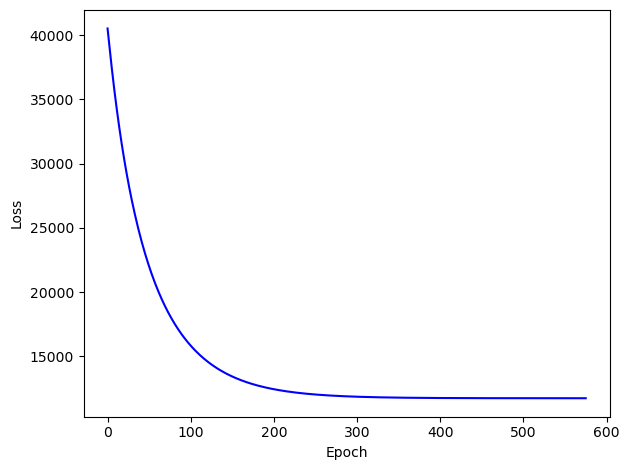

In [15]:
train_indices = np.arange(len(train_losses))
fig = plt.figure()
plt.plot(train_indices, train_losses, c='blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig.tight_layout()

/tmp/ipykernel_1566943/1467811068.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_edge['IRT1_ability'] = ability.ravel()


PearsonRResult(statistic=0.027915913885611945, pvalue=0.031652992387786155)
PearsonRResult(statistic=-0.718545967709547, pvalue=0.0)
PearsonRResult(statistic=-0.18636599122347797, pvalue=0.0)


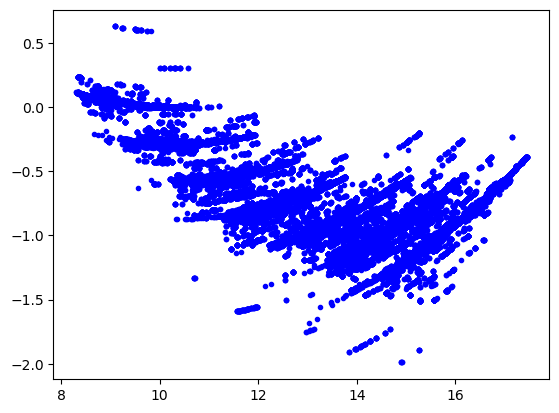

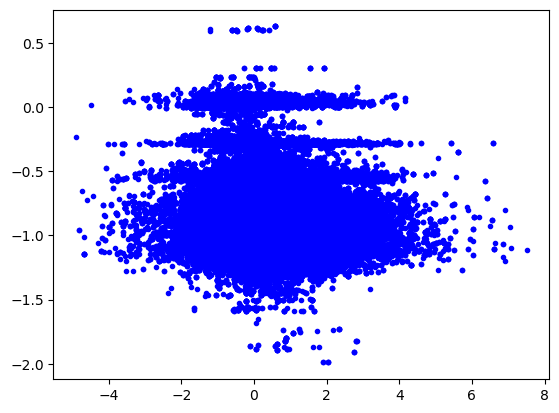

In [16]:
# save IRT parameters to matrix

if OUTNAME == 'IRT' and IRT_DIMS == 1:    
    #z_dict = model.get_embeddings(train_data.to(device))
    z_dict = output_dict['embedding_0']
    df_item['IRT1_difficulty'] = -z_dict['item']
    df_item['IRT1_discrimination'] = z_dict['offset']
    ability = z_dict['ability']
    df_edge['IRT1_ability'] = ability.ravel()
    
    aux_data = (df, df_student, df_item, df_edge, 
    train_losses, 
    train_edge_indices, val_edge_indices, test_edge_indices,
    data, train_data, val_data, test_data,
    unique_scales, unique_domains, unique_matdiff, 
    DATA_FILE)

    with open(f'./results/{OUTNAME}_aux_data_IRT1.pkl', 'wb') as handle:
        pickle.dump(aux_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    #fig = plt.figure()
    #plt.plot(df_item['IRT_difficulty'], df_item['IRT1_difficulty'], 'b.')
    df_item_clean = df_item.dropna(subset=['IRT_difficulty', 'IRT1_difficulty'])
    
    print(pearsonr(df_item_clean['IRT1_difficulty'], df_item_clean['IRT_difficulty']))
    
    edge_feat = train_data['student', 'responds', 'item'].edge_attr.detach().cpu().numpy()
    df_edge_clean = df_edge.dropna(subset=['IRT1_ability', 'ability', 'age'])
    fig = plt.figure()
    plt.plot(df_edge_clean['age'], df_edge_clean['IRT1_ability'], 'b.')
    print(pearsonr(df_edge_clean['age'], df_edge_clean['IRT1_ability']))

    fig = plt.figure()
    plt.plot(df_edge_clean['ability'], df_edge_clean['IRT1_ability'], 'b.')
    print(pearsonr(df_edge_clean['ability'], df_edge_clean['IRT1_ability']))
    